## Preparation

### Libraries
It is required to import different libraries for file and image processing, as well as for the definition and construction of neural networks using the Tensorflow library. Therefor the first step is to load all these libraries into the program:

In [1]:
import matplotlib.pyplot as plt
import glob
import os
from PIL import Image 
import numpy as np
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

### Model name

Next it is important to define the developed model in order to distinguish between different versions of the neural network. It is necesary to assign a unique name for the model before start running its training or testing. This name should be identical at the beginning of each script so that the same data is used consistently.

In [2]:
ModelNameAndVersion = "counter_det"

## Loading the training images

For this CNN, as we stated at the beginning of this section it is required to provide an input of images, that will be used to train and test the model. These images are loaded from a local directory; for this matter, it is used in this directory: 'cnnModelImages' - which can be found under the 'CNN' inside 'Code' section of the GitHub Repo.

For classification purposes, this input needs to be standardized for the program to understand them. Therefore it is also necessary for addition to the image (.jpg), that the file name is set properly and according to the following nomenclature: First Character is the identifier and the rest of the name is not relevant. 

Now the output of this section will be the proper classification of the images into two arrays `x_data` (image data) and `y_data` (classification):

In [7]:
#Setting the variables and initializing the arrays
Input_dir = 'cnnModelImages'
x_data = []
y_data = []

#Loading the image files in a loop over as jpeg images 
files = glob.glob(Input_dir + '/*.jpg')
for active_file in files:
    img = Image.open(active_file)                         #Loads the image data                  
    data = np.array(img)
    x_data.append(data)
    
    File_Name = os.path.basename(active_file)             # File_Name
    Classification = File_Name[0:1]                       # Fisrt digit will be the classification data
    if Classification == "N":                             # Handling special scenario
        category = 10                          
    else:
        category = int(Classification)
    category_vector = tf.keras.utils.to_categorical(category, 11) # Conversion to vector
    y_data.append(category_vector)

x_data = np.array(x_data)
y_data = np.array(y_data)

#print(x_data.shape)
#print(y_data.shape)

## Generate training data and test data

### Merge and slice the training

Once the data set is ready to be transferred to the model it is important to implement some functions that will allow the model to be properly fit. The first thing is to mix the loaded images, this is done with the "shuffle" function. It is important in this step to make sure that both 'x_data' and 'y_data' allocation in the array is preserved since this will allow the model to distinguish the number of images.

With the data properly mixed it is time to generate the output for this section of the code, one of the key sections, for the model. The image data is going to be divided into output sets of data: 
- Training data (`x_train` and `y_train`) 
- Test data (`x_test` and `y_test`)

Important to take into account that in this case 80% of the data will be used for training and the remaining 20% is going to be used exclusively for evaluation of the model performance. 

In [9]:
x_data, y_data = shuffle(x_data, y_data)

Testing_Percentage = 0.2       # Define the % of the total data to used for testing

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Testing_Percentage)
#print(x_train.shape)
#print(x_test.shape)

#print(y_train.shape)
#print(y_test.shape)

### Image augmentation

Some data transformation is required for the input images to be properly handled. For this specific action, there will not be much data, since this will be covered in the coming 'Development' Section of this same report. 
ImageDataGenerator function takes from the first definition section which random modifications to the input images will be implemented over the various parameters (shift, brightness, zoom, rotation) and then outputs them. 
A batch size of 4 is defined and used here, this is chosen since it has proven to be very effective when creating a network that will work with geometries. The generator is applied to both the training and test data.

In [10]:
### Without Image Augmentation - This section is just as reference for the original value of the parameters
# Shift_Range = 0
# Brightness_Range = 0
# Rotation_Angle = 0
# ZoomRange = 0

In [11]:
### With Image Augmentation
Shift_Range = 2
Brightness_Range = 0.3
Rotation_Angle = 5
ZoomRange = 0.2

datagen = ImageDataGenerator(width_shift_range  = [-Shift_Range, Shift_Range], 
                             height_shift_range = [-Shift_Range, Shift_Range],
                             brightness_range   = [1-Brightness_Range, 1+Brightness_Range],
                             zoom_range         = [1-ZoomRange, 1+ZoomRange],
                             rotation_range     = Rotation_Angle)
Batch_Size = 4
train_iterator      = datagen.flow(x_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(x_test,  y_test,  batch_size=Batch_Size)

## Definition and structure of the network
It is now the moment to identify the specifications of the implemented network. In this case, the layout consists of a sequence of convolutional and maxpooling layers.
1- The first layer is used to normalize the input data. 
2- The second layer is a "flat" layer with 512 neurons.

### Inputs
Images of size 32x20 pixels with 3 color channels --> input_shape = (32,20,3)

### Output
11 neurons: Digits 0, 1, ..., 9 + Not-A-Number (N/A) as a special case.

### Compile
Finally, the network is compiled here so that it can be used. The detailed parameters for this can be found in the relevant literature

In [12]:
model = tf.keras.Sequential()

model.add(BatchNormalization(input_shape=(32,20,3)))
model.add(Conv2D(16, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(16, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(11, activation = "softmax"))

model.summary()

model.compile(loss= tf.keras.losses.categorical_crossentropy, 
              optimizer= tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), 
              metrics = ["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 32, 20, 3)        12        
 ormalization)                                                   
                                                                 
 module_wrapper (ModuleWrapp  (None, 32, 20, 16)       448       
 er)                                                             
                                                                 
 module_wrapper_1 (ModuleWra  (None, 16, 10, 16)       0         
 pper)                                                           
                                                                 
 module_wrapper_2 (ModuleWra  (None, 16, 10, 32)       4640      
 pper)                                                           
                                                                 
 module_wrapper_3 (ModuleWra  (None, 8, 5, 32)         0

## Training the network
For training one of the more important concepts to take into account is the number of training cycles (`Epoch_Number`). 
And here also comes into play the size of the simultaneously trained images, which was previously defined as 4 (`Batch_Size`)

With these two factor the model will run over the total set of training data and will fit the model accordingly to best match the provided input.

In [13]:
Epoch_Number  = 50
history = model.fit(train_iterator, 
                    validation_data = validation_iterator, 
                    epochs          = Epoch_Number)

Epoch 1/50
98/98 [==============================] - 3s 18ms/step - loss: 2.1443 - accuracy: 0.4158 - val_loss: 2.0649 - val_accuracy: 0.3469
Epoch 2/50
98/98 [==============================] - 1s 13ms/step - loss: 1.9682 - accuracy: 0.4158 - val_loss: 1.9113 - val_accuracy: 0.3571
Epoch 3/50
98/98 [==============================] - 1s 13ms/step - loss: 1.7875 - accuracy: 0.4413 - val_loss: 1.8866 - val_accuracy: 0.3673
Epoch 4/50
98/98 [==============================] - 1s 13ms/step - loss: 1.5501 - accuracy: 0.5051 - val_loss: 1.5655 - val_accuracy: 0.5000
Epoch 5/50
98/98 [==============================] - 1s 13ms/step - loss: 1.5007 - accuracy: 0.5204 - val_loss: 1.5421 - val_accuracy: 0.4796
Epoch 6/50
98/98 [==============================] - 1s 13ms/step - loss: 1.2596 - accuracy: 0.5893 - val_loss: 1.3638 - val_accuracy: 0.5102
Epoch 7/50
98/98 [==============================] - 1s 13ms/step - loss: 1.1482 - accuracy: 0.6352 - val_loss: 1.1886 - val_accuracy: 0.6327
Epoch 8/50
98

### Visualization of training
The model is now ready to use. 
For a better understanding of the output, one can be visualized how the training was performed. 
For this matter, the error is used, both in the training data as well as in the test data.

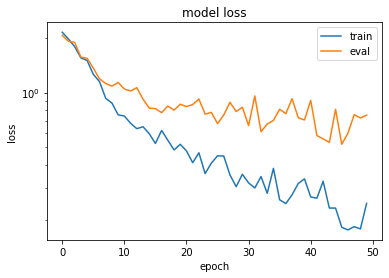

In [14]:
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper right')
plt.show()

## Saving the Neural Network
Last step is to get the outputed neural network saved for further use. 
The complete network is first saved here in the so-called H5 format.

In [15]:
## H5-Format
model.save('saved_model/' + ModelNameAndVersion)

INFO:tensorflow:Assets written to: saved_model/counter_det\assets


INFO:tensorflow:Assets written to: saved_model/counter_det\assets
